In [29]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage
from scipy.signal import find_peaks

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, kernelFind, convCircle

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120


In [16]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img, (yC, xC)

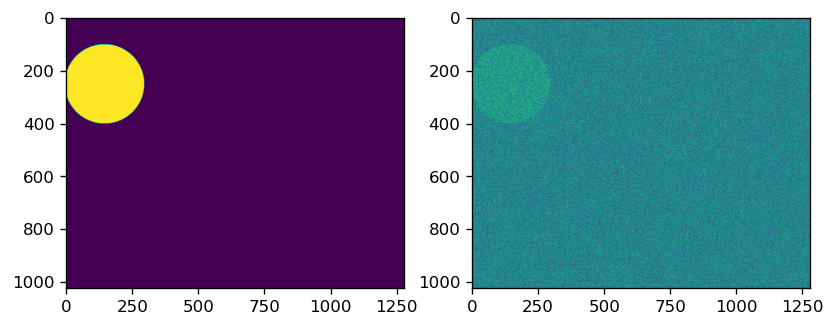

In [17]:
noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=2, noise=10, minRadius=150, maxRadius=150)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(img[0])
ax[1].imshow(noisyImg[0])
plt.show()

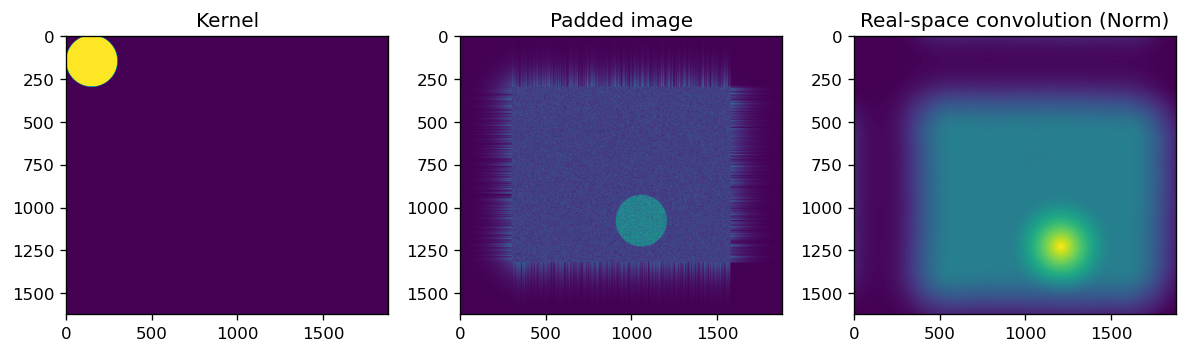

In [26]:
radius = 150
costArr = convCircle(noisyImg[0], 150, debug=True, fftPadding=300)
maxPoints = np.where(costArr == np.max(costArr))
maxPoints = (maxPoints[0][0], maxPoints[1][0])
#costArr = convCircle(image[:,:,0]*maskArr[:,:,0], radius, fftPadding=1)

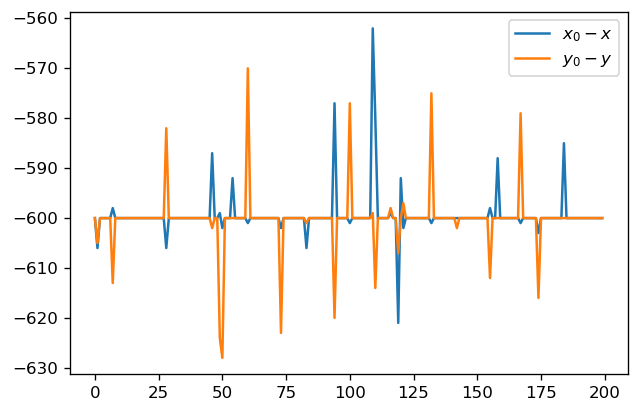

In [34]:
xDiffArr = np.zeros(200)
yDiffArr = np.zeros(200)

radius = 150

for i in range(200):
    noisyImg, img, center = genTrainingImages((1024, 1280), 1, minCircles=1, maxCircles=2, noise=5, minRadius=150, maxRadius=150)
    costArr = convCircle(noisyImg[0], radius, debug=False, fftPadding=int(radius*3))
    maxPoint = np.where(costArr == np.max(costArr))
    maxPoint = (maxPoint[0][0], maxPoint[1][0])
    
    yDiffArr[i] = center[0] - maxPoint[0]
    xDiffArr[i] = center[1] - maxPoint[1]
    
plt.plot(yDiffArr, label='$x_0 - x$')
plt.plot(xDiffArr, label='$y_0 - y$')
plt.legend()
plt.show()

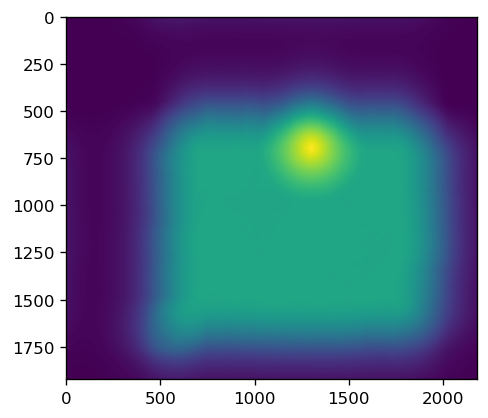

In [35]:
plt.imshow(np.abs(costArr))

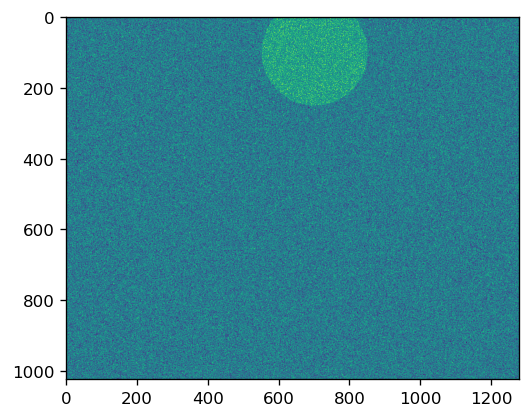

In [37]:
plt.imshow(noisyImg[0])

In [38]:
find_peaks(costArr)

/home/jack/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


ValueError: `x` must be a 1-D array